<a href="https://colab.research.google.com/github/adoumouangnamouemmanuel/AirBnB_clone/blob/master/Model_To_Recognize_Cards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
gpiosenka_cards_image_datasetclassification_path = kagglehub.dataset_download('gpiosenka/cards-image-datasetclassification')

print('Data source import complete.')

100%|██████████| 385M/385M [00:08<00:00, 48.0MB/s]

Extracting files...


Data source import complete.


# Cards image recognition model
**Created By Emmanuel ADOUM**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
PyTorch version 2.5.1+cu121
Torchvision version 0.20.1+cu121
Numpy version 1.26.4
Pandas version 2.2.3


## Step 1. Pytorch Dataset (and Dataloader)

### Dataset

In [ ]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [ ]:
path = "/kaggle/input/cards-image-datasetclassification"
dataset = PlayingCardDataset(data_dir = path)

In [ ]:
len(dataset)

8154

0


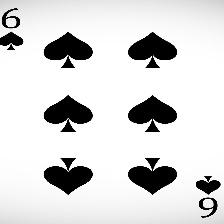

In [ ]:
image, label = dataset[200]
print(label)
image

In [ ]:
target_to_class = dataset.classes
target_to_class

['test', 'train', 'valid']

In [ ]:
dr = "/kaggle/input/cards-image-datasetclassification/train"
targets = ImageFolder(dr).class_to_idx

In [ ]:
targets

{'ace of clubs': 0,
 'ace of diamonds': 1,
 'ace of hearts': 2,
 'ace of spades': 3,
 'eight of clubs': 4,
 'eight of diamonds': 5,
 'eight of hearts': 6,
 'eight of spades': 7,
 'five of clubs': 8,
 'five of diamonds': 9,
 'five of hearts': 10,
 'five of spades': 11,
 'four of clubs': 12,
 'four of diamonds': 13,
 'four of hearts': 14,
 'four of spades': 15,
 'jack of clubs': 16,
 'jack of diamonds': 17,
 'jack of hearts': 18,
 'jack of spades': 19,
 'joker': 20,
 'king of clubs': 21,
 'king of diamonds': 22,
 'king of hearts': 23,
 'king of spades': 24,
 'nine of clubs': 25,
 'nine of diamonds': 26,
 'nine of hearts': 27,
 'nine of spades': 28,
 'queen of clubs': 29,
 'queen of diamonds': 30,
 'queen of hearts': 31,
 'queen of spades': 32,
 'seven of clubs': 33,
 'seven of diamonds': 34,
 'seven of hearts': 35,
 'seven of spades': 36,
 'six of clubs': 37,
 'six of diamonds': 38,
 'six of hearts': 39,
 'six of spades': 40,
 'ten of clubs': 41,
 'ten of diamonds': 42,
 'ten of hearts':

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [ ]:
dr = "/kaggle/input/cards-image-datasetclassification/train"
dataset = PlayingCardDataset(dr, transform)

In [ ]:
image, label = dataset[100]
image

tensor([[[0.0000, 0.0039, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0078, 0.0431,  ..., 0.0196, 0.0039, 0.0078],
         [0.0235, 0.0392, 0.3490,  ..., 0.2392, 0.0314, 0.0118],
         ...,
         [0.0039, 0.0235, 0.2392,  ..., 0.2196, 0.0314, 0.0118],
         [0.0039, 0.0039, 0.0235,  ..., 0.0118, 0.0078, 0.0039],
         [0.0039, 0.0078, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0078, 0.0078, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0392,  ..., 0.0196, 0.0039, 0.0078],
         [0.0078, 0.0275, 0.3373,  ..., 0.2392, 0.0275, 0.0078],
         ...,
         [0.0039, 0.0235, 0.2431,  ..., 0.2196, 0.0314, 0.0078],
         [0.0039, 0.0039, 0.0235,  ..., 0.0157, 0.0078, 0.0039],
         [0.0039, 0.0078, 0.0039,  ..., 0.0078, 0.0078, 0.0039]],

        [[0.0196, 0.0196, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0078, 0.0353,  ..., 0.0157, 0.0039, 0.0078],
         [0.0118, 0.0196, 0.3137,  ..., 0.2196, 0.0235, 0.

In [ ]:
image.shape

torch.Size([3, 128, 128])

In [ ]:
# iterate over dataset
for image, label in dataset:
    print(label)
    break

0


### DataLoaders
* Batching our dataset

In [ ]:
dataloader = DataLoader(dataset, batch_size = 32, shuffle=True)

In [ ]:
for images, labels in dataloader:
    print(labels)
    break

tensor([44, 19, 33, 11, 52, 19, 39, 26, 47, 28,  9, 30, 16, 11, 26,  0, 17,  7,
        47, 23, 23, 11, 20, 22, 41, 34, 52, 47, 21, 44, 39, 38])


## Step 2. Pytorch Model

In [ ]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [ ]:
model = SimpleCardClassifer()

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
output_ex = model(images)

## Step 3. The training loop

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
criterion(output_ex, labels)

tensor(4.0492, grad_fn=<NllLossBackward0>)

### Set up Datasets

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '../input/cards-image-datasetclassification/train/'
valid_folder = '../input/cards-image-datasetclassification/valid/'
test_folder = '../input/cards-image-datasetclassification/test/'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Simple training loop

In [ ]:
# Simple training loop
num_epochs = 10
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10 - Train loss: 1.6409129138258047, Validation loss: 0.546987946753232


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/10 - Train loss: 0.5757361813081899, Validation loss: 0.42343811493999556


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/10 - Train loss: 0.337593638524804, Validation loss: 0.12715961157150987


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/10 - Train loss: 0.2243129736338307, Validation loss: 0.14849970948021368


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/10 - Train loss: 0.2040059861862897, Validation loss: 0.12463008835911751


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/10 - Train loss: 0.17772411026553117, Validation loss: 0.27295143019478274


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/10 - Train loss: 0.15347254005869596, Validation loss: 0.13308424255195653


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/10 - Train loss: 0.1106083508588741, Validation loss: 0.1560607784761573


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/10 - Train loss: 0.10089332197772306, Validation loss: 0.19369656315670822


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/10 - Train loss: 0.1044545742572683, Validation loss: 0.1268961364368223


### Visualize Losses

We can plot our training and validation loss through this training, usually we do this at the end of each epoch. We see that our accuracy on the validation dataset is `x`! There are a LOT more things to learn about that can drastically improve how to train a model which I will cover in future videos, but this should give you a good start!



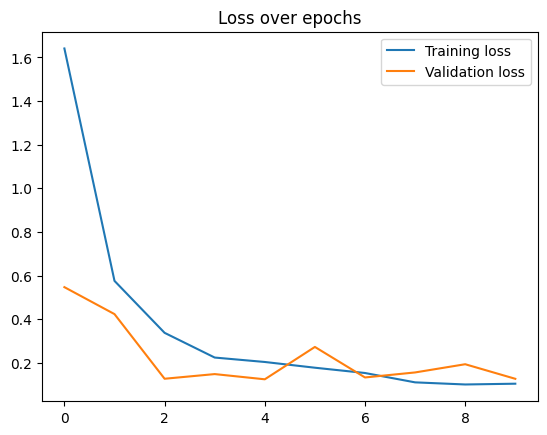

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Bonus: Evaluating the Results

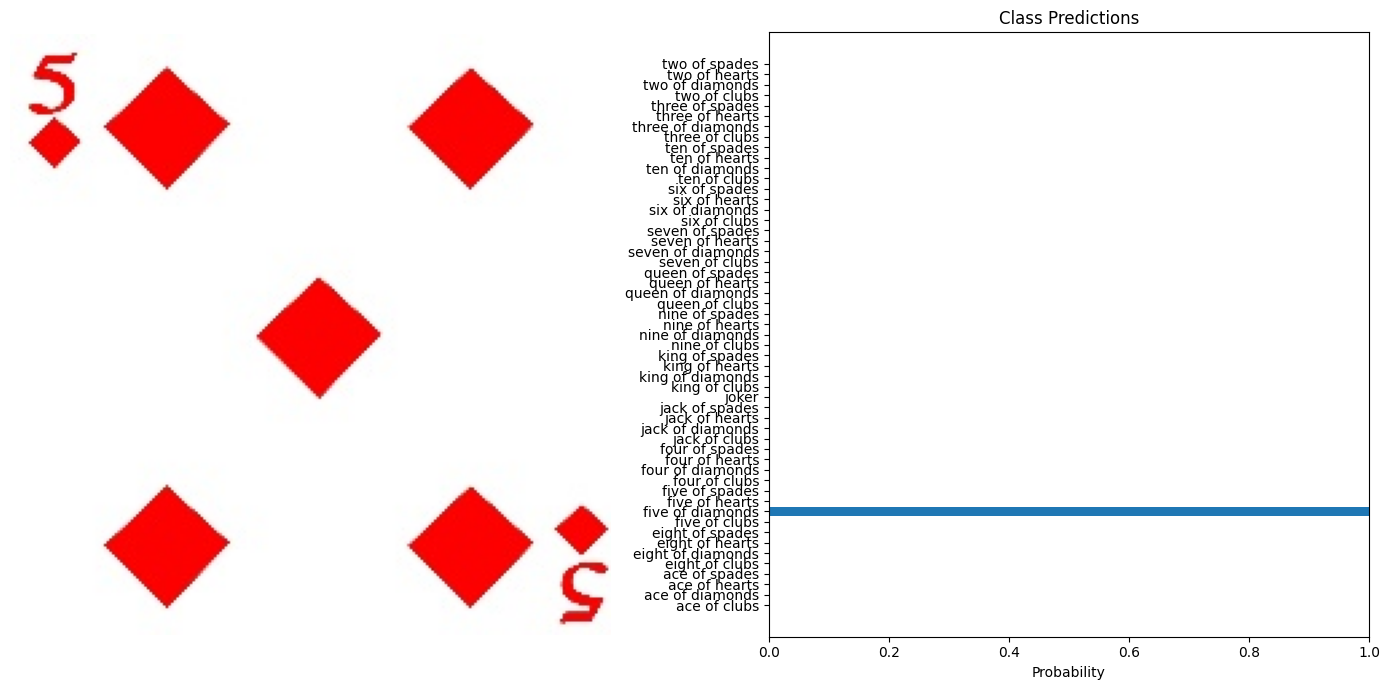

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/kaggle/input/cards-image-datasetclassification/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)

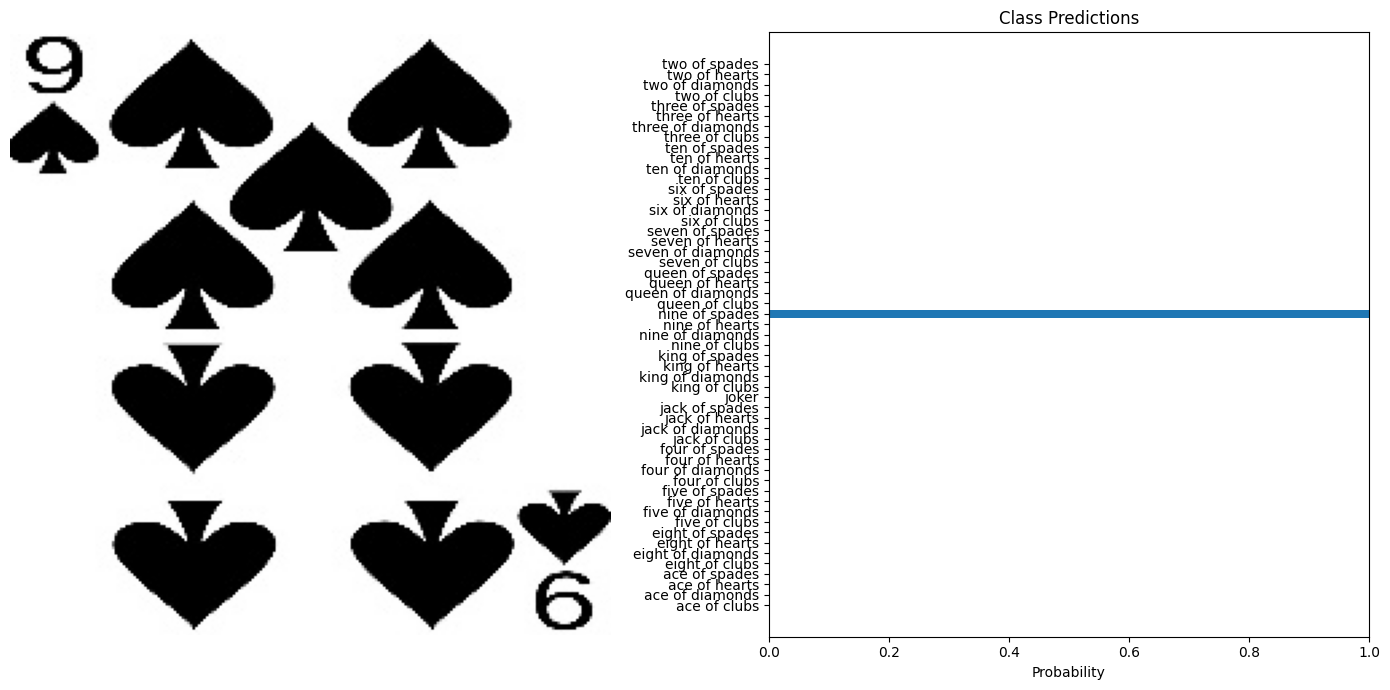

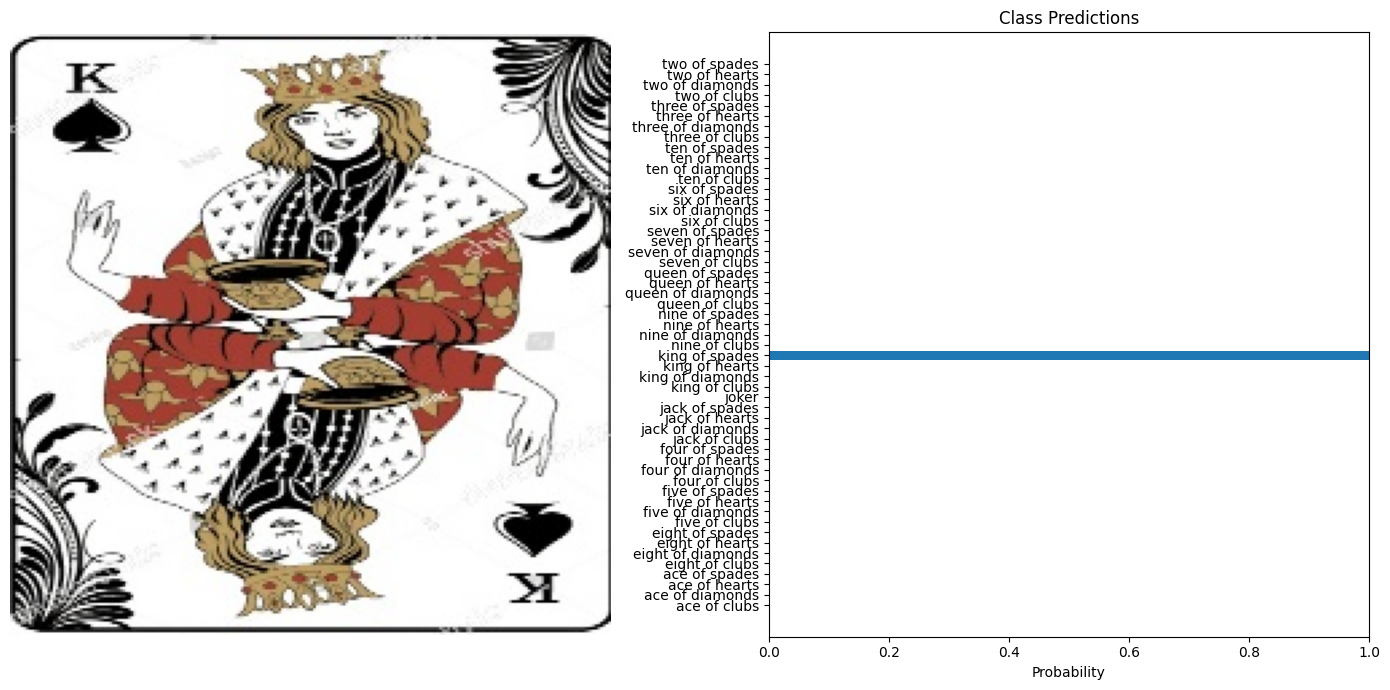

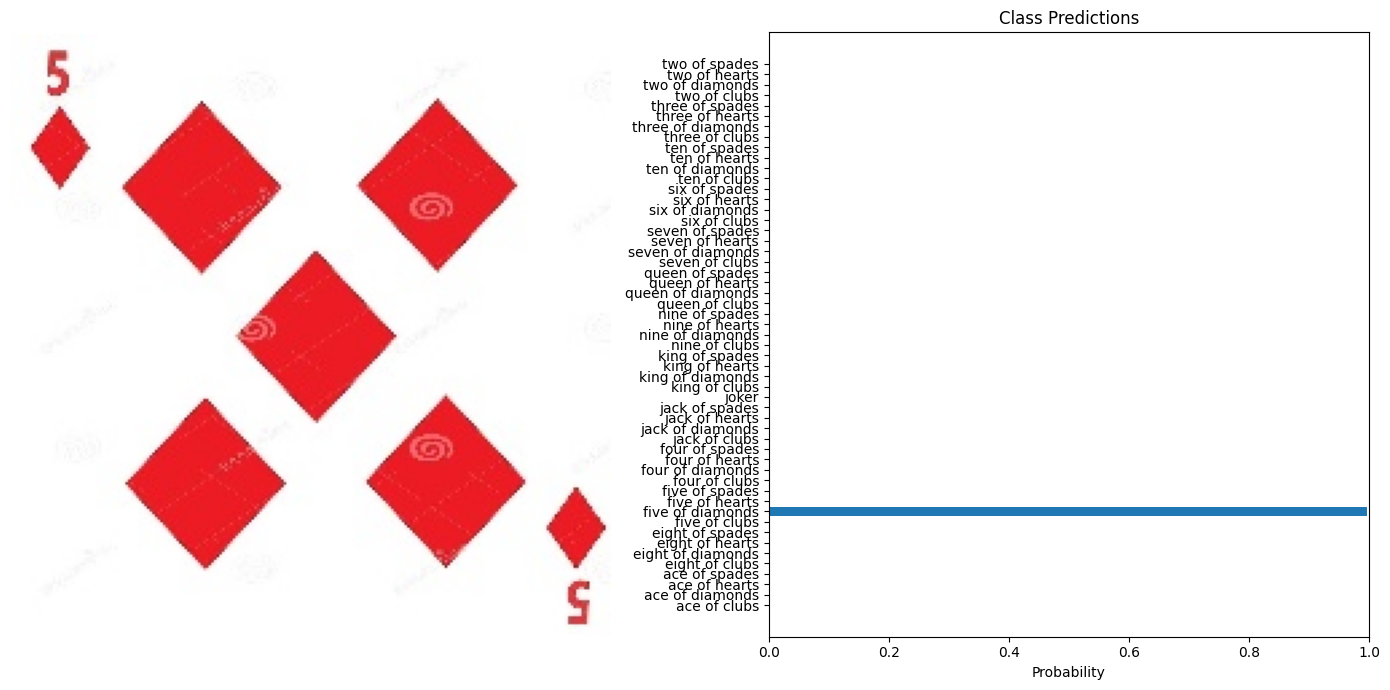

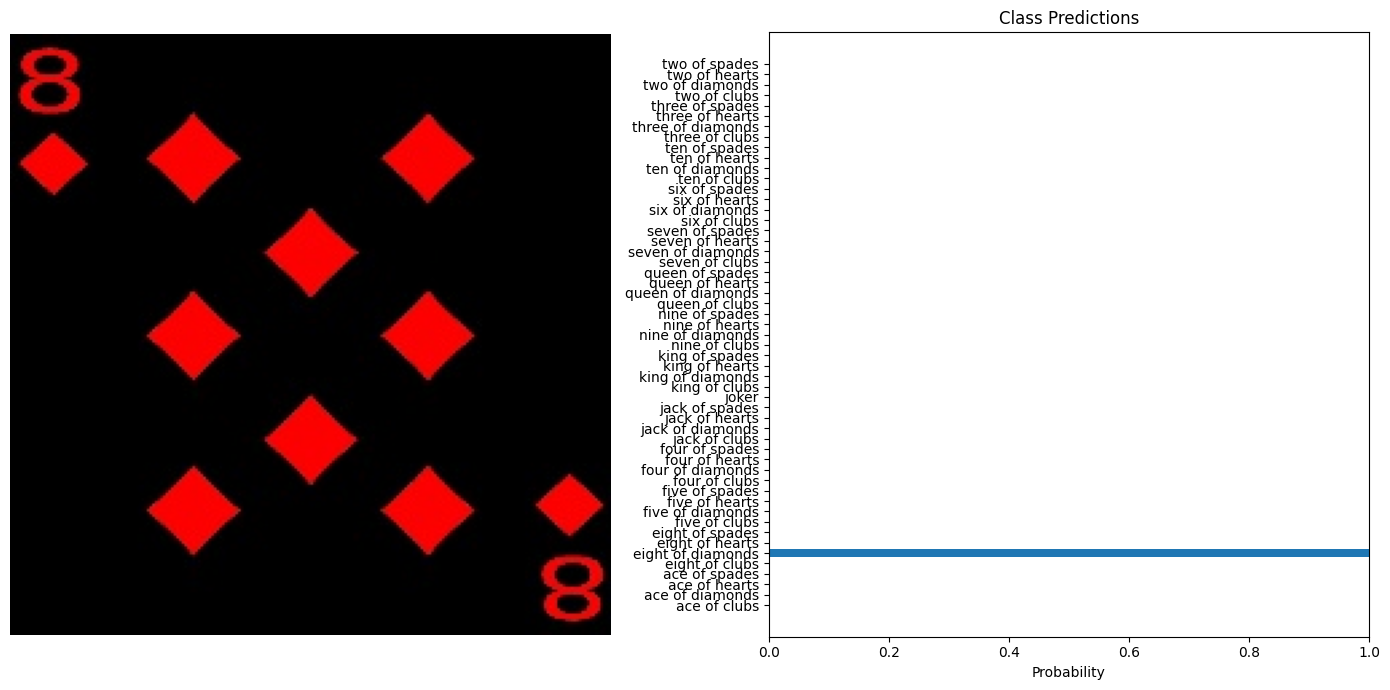

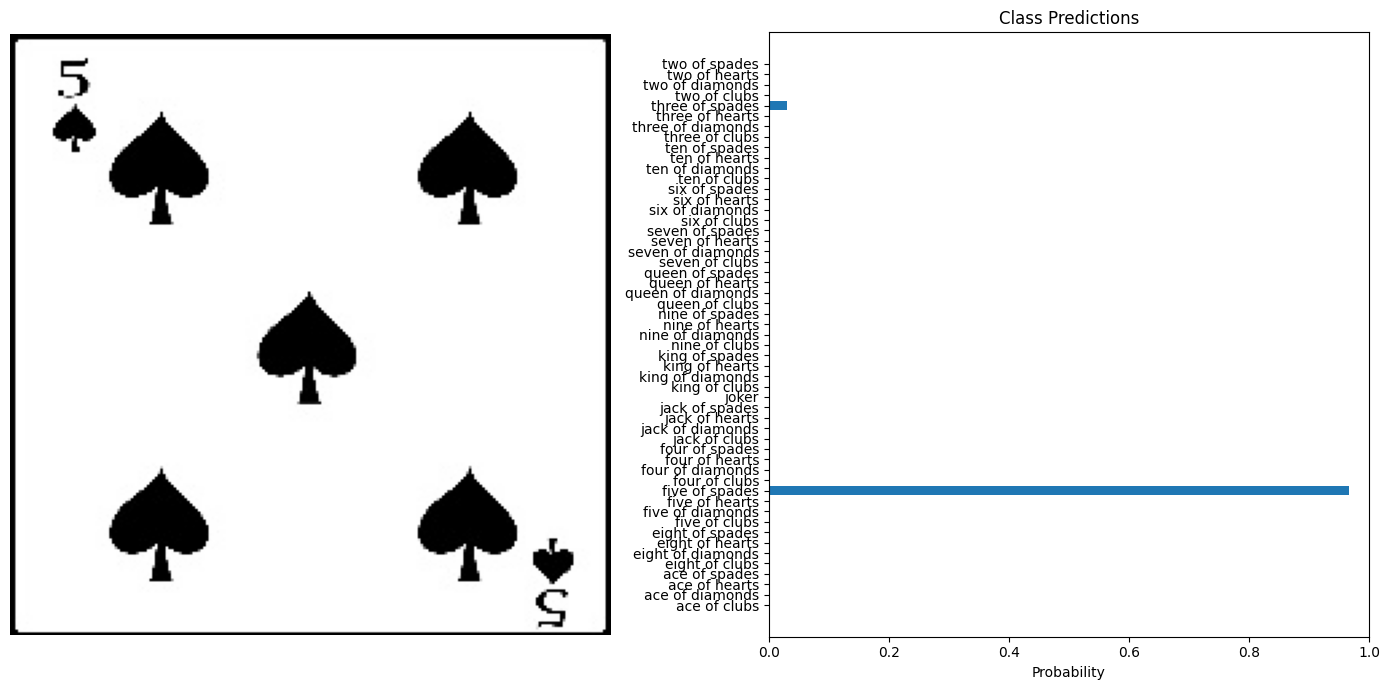

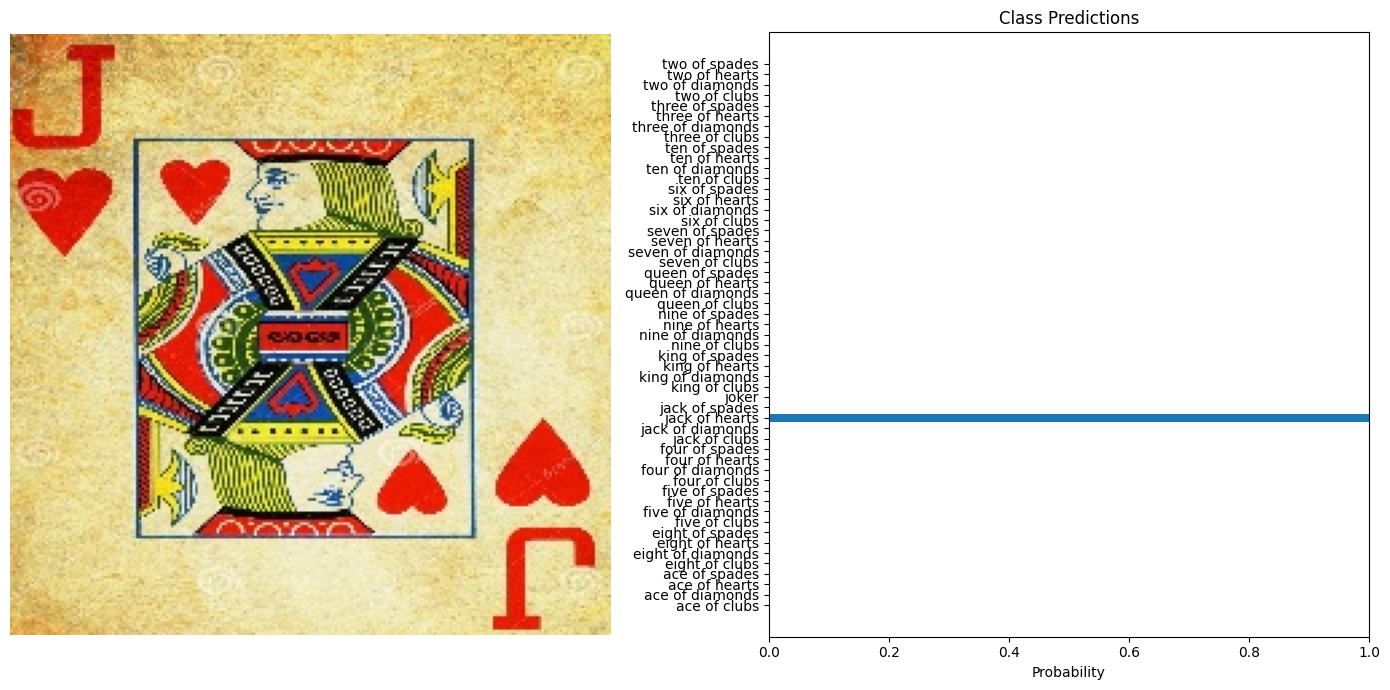

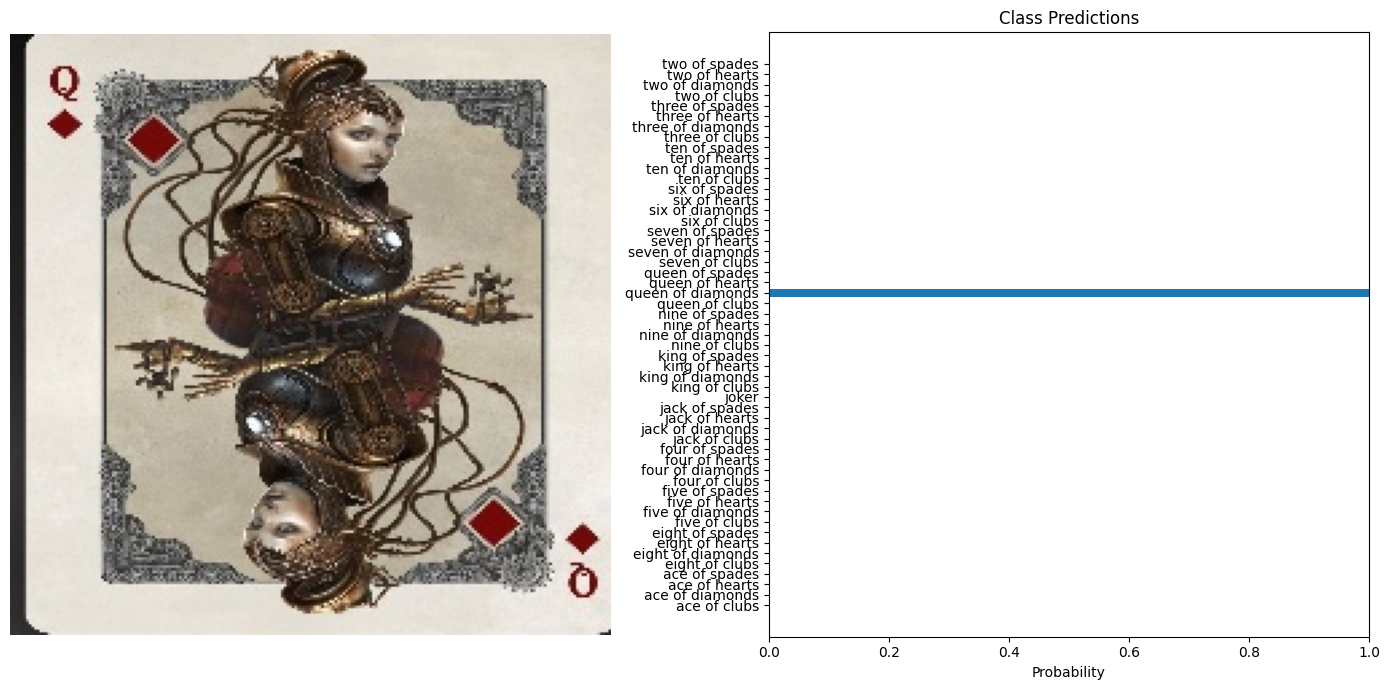

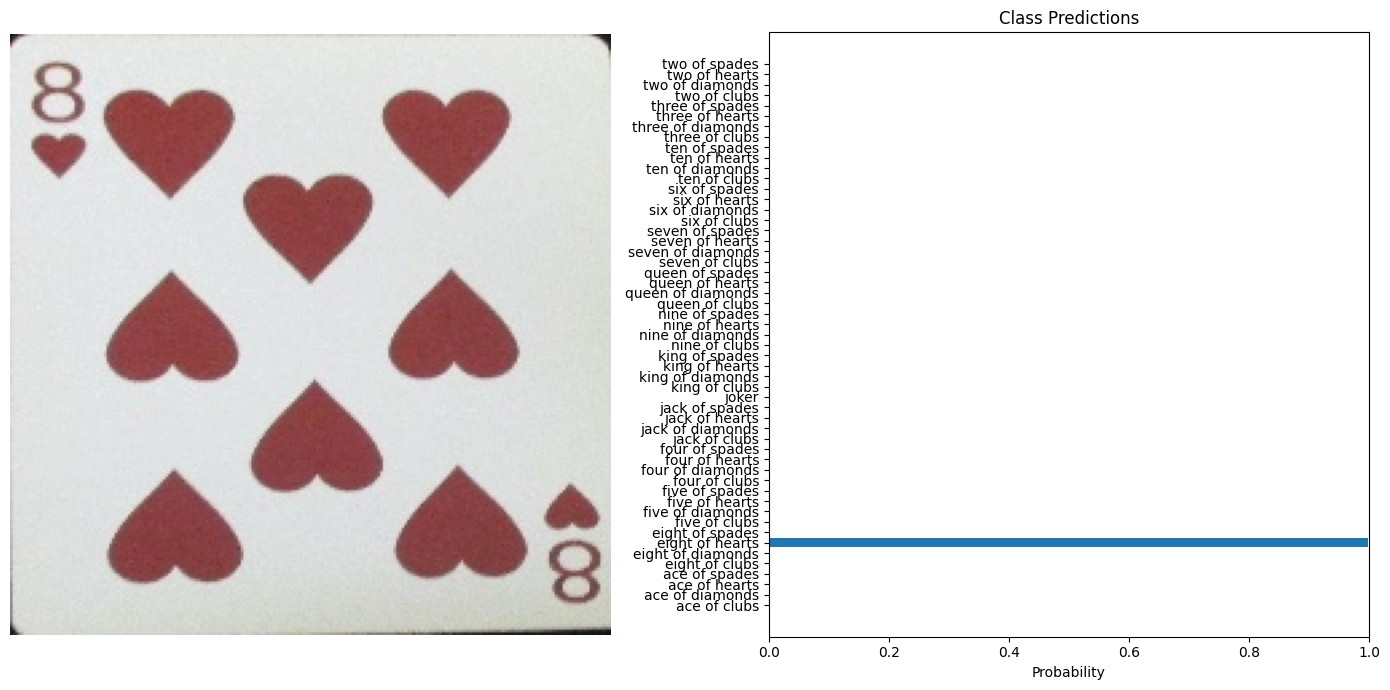

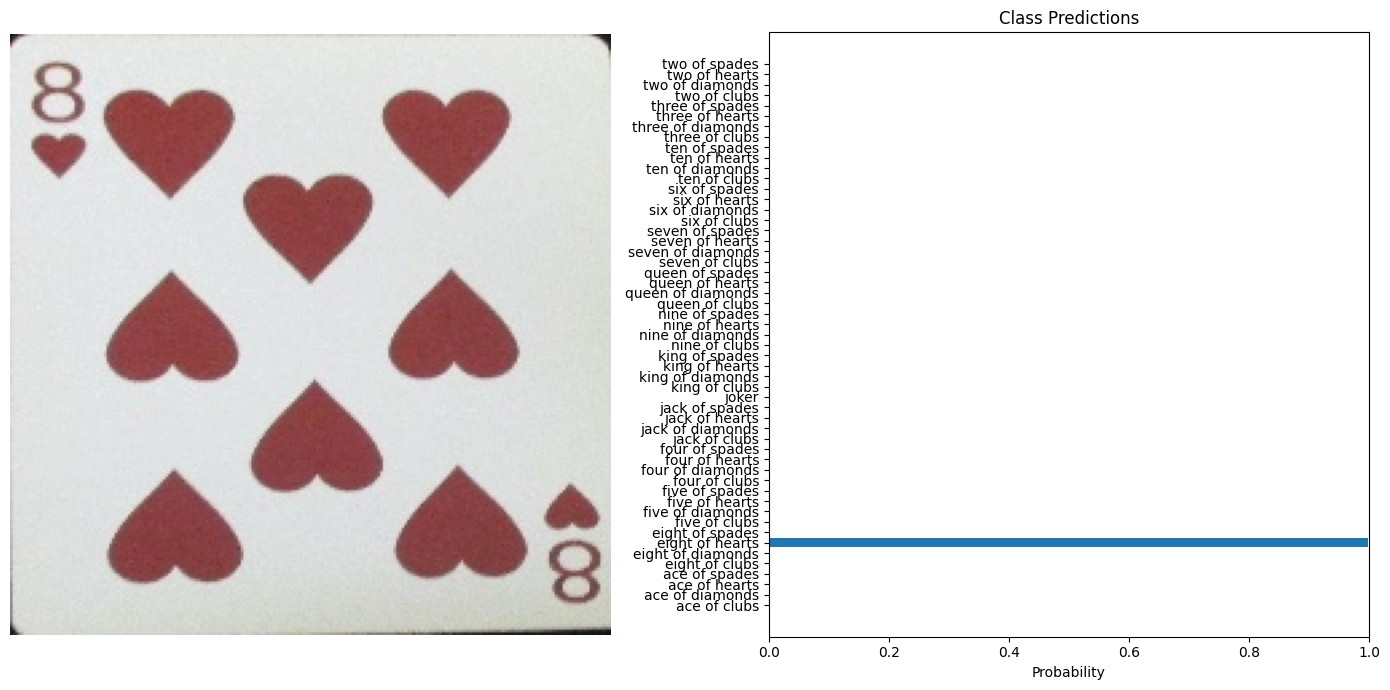

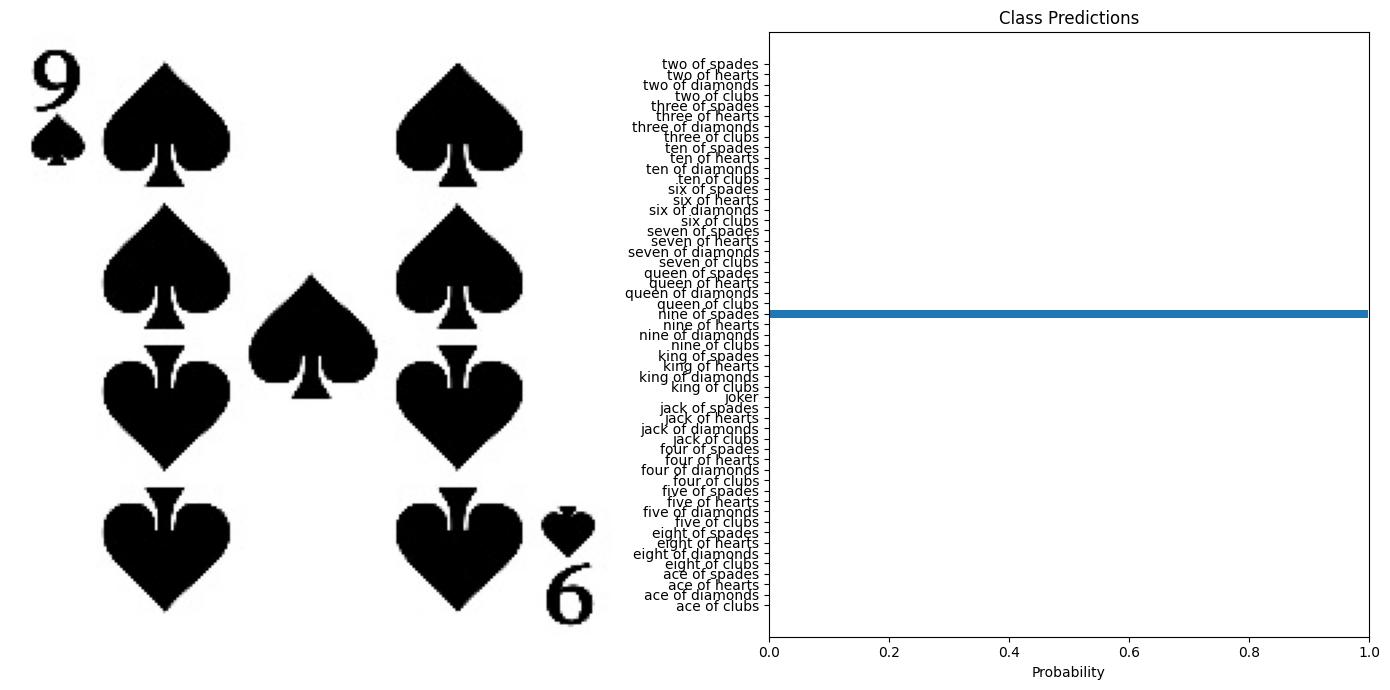

In [ ]:
from glob import glob
test_images = glob('../input/cards-image-datasetclassification/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes
    visualize_predictions(original_image, probabilities, class_names)

## Step 4. Accuracy calculation

### Validation

In [ ]:
# Initialize variables to track correct predictions and total predictions
correct_preds_val = 0
total_preds_val = 0

# Switch the model to evaluation mode
model.eval()

# No gradient calculation is needed during evaluation
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Validation loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Get model predictions
        outputs = model(images)

        # Get predicted class labels (the index of the max probability)
        _, predicted = torch.max(outputs, 1)

        # Calculate the number of correct predictions
        correct_preds_val += (predicted == labels).sum().item()
        total_preds_val += labels.size(0)

# Calculate accuracy for validation set
accuracy_val = correct_preds_val / total_preds_val
print(f"Validation Accuracy: {accuracy_val * 100:.2f}%")

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Validation Accuracy: 96.23%


### Test Accuracy

In [ ]:
import os

# Function to extract the true label from the file path
def get_true_label(image_path, class_names):
    # Extract the class name from the folder structure (the parent folder name)
    class_name = os.path.basename(os.path.dirname(image_path))

    # Find the index of the class name in the class_names list
    label = class_names.index(class_name)

    return label

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes

    # Extract true label for the current image
    true_label = get_true_label(example, class_names)

    # Convert probabilities to a PyTorch tensor
    probabilities_tensor = torch.tensor(probabilities)

    # Get predicted class label
    predicted_label = torch.argmax(probabilities_tensor)  # Predicted class index

    # Update the correct predictions count
    correct_preds_test += (predicted_label.item() == true_label)
    total_preds_test += 1

# Calculate accuracy for test set
accuracy_test = correct_preds_test / total_preds_test
print(f"Test Accuracy: {accuracy_test * 100:.2f}%")

Test Accuracy: 100.00%
